In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

# 梯度消失和梯度爆炸

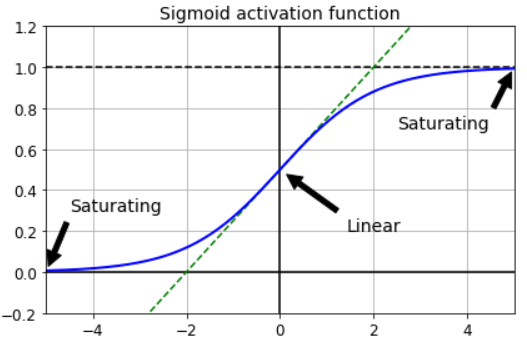

例如使用sigmoid函数作为激活函数，传统的权重初始化方法，如标准正态分布下，每一层输出的方差都远大于其输入的方差，随着网络的延申，方差会不断增加，直到激活函数达到饱和。

输入过大或过小时，其导数几乎为0，难以反向传播，此时饱和，为梯度消失，反向传播通过顶层向下传播时，存在的小梯度不断被稀释，因此对于底层来说什么都没有留下。

## Glorot和He初始化

权重初始化

$fan_{avg} = (fan_{in} + fan_{out}) / 2$ ，其中$fan_{in}$是该层的扇入，$fan_{in}$是扇出

Glorot初始化（sigmoid激活函数）

正态分布，均值为0，方差为 $\sigma^2=\frac{1}{fan_{avg}}$

或$-r$到$+r$之间的均匀分布，其中 $r = \sqrt{\frac{3}{fan_{avg}}}$

In [2]:
[name for name in dir(keras.initializers) if not name.startswith("_")][:10]  # 一些可选择的初始化参数

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones']

## 非饱和激活函数

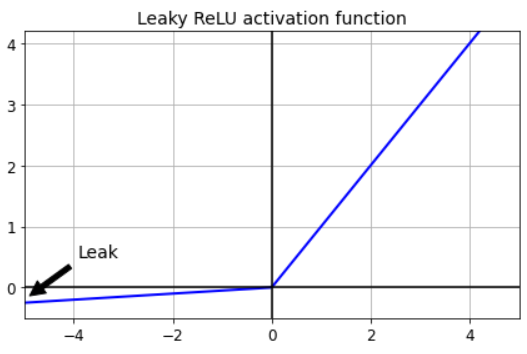

In [3]:
[m for m in dir(keras.activations) if not m.startswith("_")]
# 一些可用的激活函数

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [4]:
[m for m in dir(keras.layers) if "relu" in m.lower()]
# 可用的激活函数中ReLU的变体

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [6]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),  # 给前面一层用LeakyReLU激活函数
    # keras.layers.PReLU()， PReLU激活函数同理
    # keras.layers.Dense(10, activation="elu") elu激活函数
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),  # 同理
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [7]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 1ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7658
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6816 - accuracy: 0.7720 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5338 - accuracy: 0.8225 - val_loss: 0.5157 - val_accuracy:

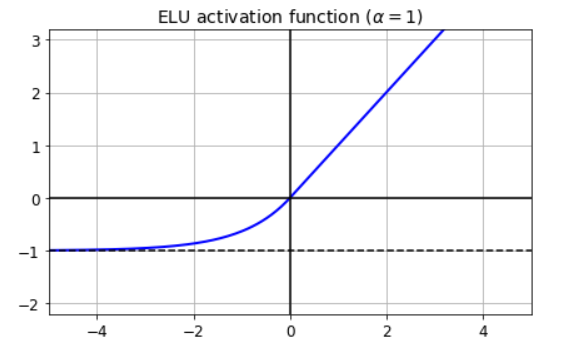
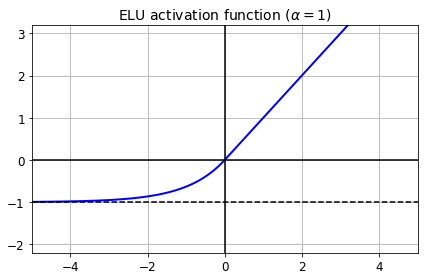

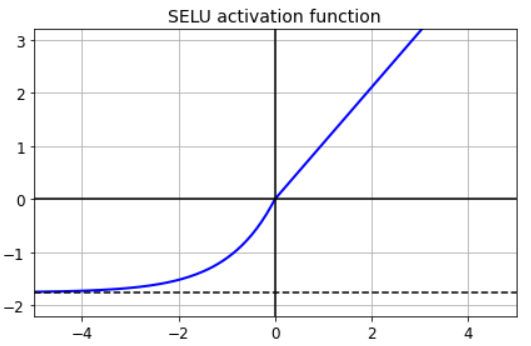

SELU的实现不再作演示，参考https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb
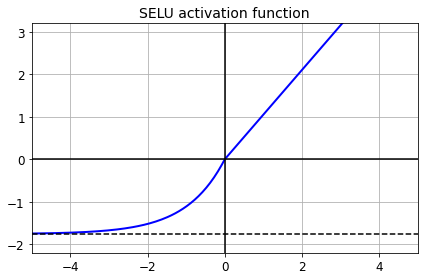

## 批量归一化

1. $\mu_B = \frac{1}{m_{B}}\sum^{m_B}_{i=1}x^{(i)} $
2. $\sigma^2 = \frac{1}{m_{B}}\sum^{m_B}_{i=1}(x^{(i)}-\mu_B)^2 $
3. $\hat{x}^{(i)} = \frac{x^{(i)}-\mu_B}{\sqrt{\sigma_b^{(B)}+\epsilon}} $
4. $z^{(i)} = \gamma\bigotimes\hat{x}^{(i)}+\beta $  ，(逐元素乘法)

In [8]:
'''
在激活函数之后归一化
'''

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),  # 每一层中间都批量归一化
    keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

批量归一化层（BN层）每个扇入增加四个参数，因此每一层增加（扇入\*4）个参数，其中 $\mu$ 和 $\sigma$ 是移动平均值，不受反向传播影响，因此BN层有一半的参数为非训练参数（但也是估算出来的，因此也可以认为是半训练参数）

In [12]:
[(var.name, var.trainable) for var in model.layers[1].variables]  # 检查参数

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [15]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.9123 - accuracy: 0.6962 - val_loss: 0.5906 - val_accuracy: 0.8036
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6127 - accuracy: 0.7894 - val_loss: 0.5002 - val_accuracy: 0.8336
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5484 - accuracy: 0.8106 - val_loss: 0.4618 - val_accuracy: 0.8422
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5075 - accuracy: 0.8235 - val_loss: 0.4382 - val_accuracy: 0.8508
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4800 - accuracy: 0.8327 - val_loss: 0.4223 - val_accuracy: 0.8558
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4640 - accuracy: 0.8375 - val_loss: 0.4101 - val_accuracy: 0.8612
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4495 - accuracy: 0.8426 - val_loss: 0.3988 - val_accuracy:

相对于之前的，训练速度慢了，之前2秒，现在4秒，但在超大型数据中，实际上差不多甚至更短

In [24]:
'''
在激活函数前归一化
'''

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False), # 取消偏置项，在归一化中已经加了偏置项
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [30]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=1e-3),
             metrics=['accuracy'])

In [31]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 1.1188 - accuracy: 0.6457 - val_loss: 0.7041 - val_accuracy: 0.7750
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7077 - accuracy: 0.7685 - val_loss: 0.5781 - val_accuracy: 0.8052
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6217 - accuracy: 0.7915 - val_loss: 0.5199 - val_accuracy: 0.8266
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5687 - accuracy: 0.8099 - val_loss: 0.4841 - val_accuracy: 0.8350
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5331 - accuracy: 0.8173 - val_loss: 0.4604 - val_accuracy: 0.8432
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5098 - accuracy: 0.8247 - val_loss: 0.4410 - val_accuracy: 0.8508
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4923 - accuracy: 0.8304 - val_loss: 0.4271 - val_accuracy:

## 梯度裁剪

In [32]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)  
# 按值裁剪，原始梯度向量为[0.9, 100]，则裁剪为[0.9, 1]，范围限定在[-1, 1]
optimizer = keras.optimizers.SGD(clipnorm=1.0)
# 按范数裁剪，原始梯度向量为[0.9, 100]，则裁剪为[0.00899964, 0.9999595]，第一个分量基本消除，但方向保留
model.compile(loss='mse', optimizer=optimizer)